<a href="https://colab.research.google.com/github/pumazzo/ML4HS-UC/blob/main/Notebook_7_1_ML4HS_UC2023_Integrated_Gradients_e_TracIn_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# xAI handOn based on the first one!

Slide for xAI and TracIn ([SLIDE](https://docs.google.com/presentation/d/1YkYls7ElSjxKW-HG2sMPlymSuKcLjBCtH77n8LVVNLA/edit?usp=sharing))


Jamborad for today ([BOARD](https://jamboard.google.com/d/1MAaDvaBTjy3RluS62r8mXKiOI6ZWDKc8Mn7BZap62eA/edit?usp=sharing))

[PAPER INTEGRATED GRADIENTS](https://arxiv.org/pdf/1703.01365.pdf)

[PAPER TRACIN](https://arxiv.org/pdf/2002.08484.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Load the MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])

train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainset, valiset = torch.utils.data.random_split(
        train, [50000, 10000], generator=torch.Generator().manual_seed(1))

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)
valiloader = torch.utils.data.DataLoader(valiset, batch_size=128, shuffle=False)

In [ ]:
len(trainset)

50000

In [ ]:
# Define the neural network model
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        # Dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        #print(x.shape)
        # Flatten the tensor
        x = x.view(-1, 64 * 3 * 3)
        # Apply dropout
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x






In [ ]:
model = Net()
from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,28,28))
else:
  summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          18,496
         MaxPool2d-6             [-1, 64, 3, 3]               0
           Dropout-7                  [-1, 576]               0
            Linear-8                   [-1, 64]          36,928
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
           Linear-11                   [-1, 10]             650
Total params: 65,034
Trainable params: 65,034
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Lets create all the folders needed

In [ ]:
import os
def CreateDir(path):
	# Create a directory if it does not exist
	success = os.path.exists(path)
	if not success:
		os.makedirs(path)
CreateDir("results")#
CreateDir("results/display")
CreateDir("results/preprocess")
#CreateDir("data")

In [ ]:
trainset[2][1]

0

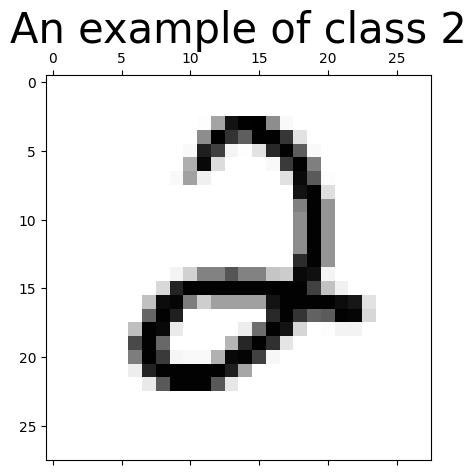

In [ ]:
import matplotlib.pyplot as plt
to_plot = 10
def plot_example(trainset,to_plot):
  image = trainset[to_plot][0][0].detach().cpu().numpy()
  lab = trainset[to_plot][1]
  f,ax = plt.subplots(1,1,figsize=(5,5))
  ax.matshow(image,cmap="Greys")
  ax.set_title("An example of class {}".format(lab),fontsize=30)

plot_example(trainset,to_plot)

In [ ]:


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
def accuracy(y_pred, y_true):
    """
    Calculates the accuracy of the predicted labels.

    Args:
        y_pred (torch.Tensor): predicted labels
        y_true (torch.Tensor): true labels

    Returns:
        float: accuracy score
    """
    # Get the predicted class by finding the index of the maximum value along axis 1
    y_pred = torch.argmax(y_pred, axis=1)
    #y_true = torch.argmax(y_true, axis=1)

    # Calculate the number of correctly classified examples
    correct = (y_pred == y_true).sum().item()

    # Calculate the total number of examples
    total = len(y_true)

    # Calculate the accuracy
    acc = correct / total

    return acc

In [ ]:
# Define the number of epochs and the patience for early stopping
num_epochs = 15
patience = 3
TRAIN = 1

# Initialize the variables for tracking the best validation accuracy and the number of epochs since the best accuracy
best_val_acc = 0.0
epochs_since_best_val_acc = 0

train_curve=[]
val_curve=[]
lr_curve=[]

lr_ckp=[]

if TRAIN:
  # Train loop
  for epoch in range(num_epochs):# the network train on all the elements
      # Training
      model.train()
      tmp_loss = 0
      for batch_idx, (data, target) in enumerate(trainloader): # divide the problem in batches
          # Forward pass


          output = model(data)# output will be something [batch,4]
          loss = criterion(output, target)

          # Backward pass and optimization
          optimizer.zero_grad()# clear the previous gradients
          loss.backward()# compute gradient of loss
          optimizer.step()# update the weigths

          tmp_loss += loss.detach().numpy()

      if epoch > 5:
        scheduler.step()

      lr_curve.append(optimizer.param_groups[0]['lr'])
      train_curve.append(tmp_loss/len(trainloader))
      # Validation
      model.eval() # the validation step do NOT change the parameters
      with torch.no_grad():
          val_acc = 0.0
          val_total = 0
          val_loss = 0
          for data, target in valiloader:
              output = model(data)
              val_loss += criterion(output, target).item()


              val_acc += accuracy(output, target)

          val_acc /=  len(valiloader)
          val_loss /= len(valiloader)
          val_curve.append(val_loss)

          print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, lr: {optimizer.param_groups[0]['lr']:.3e}")

          # Check if the validation accuracy has improved
          if val_acc > best_val_acc:
              best_val_acc = val_acc
              epochs_since_best_val_acc = 0
              best_weights = model.state_dict()
              torch.save(best_weights, 'results/best_weights.pth')
              print("Best!")
              best_epoch = epoch
          else:
              epochs_since_best_val_acc += 1

          if ((epoch+1) % 2)==0 & (epoch<10) :

            weights = model.state_dict()
            torch.save(weights, 'results/ckp_{}.pth'.format(epoch+1))
            print("ckp saved!")
            lr_ckp.append(optimizer.param_groups[0]['lr'])

          # Check if early stopping is necessary
          if epochs_since_best_val_acc >= patience:
              print("Early stopping!")
              break


  np.save("lr_ckp.npy",lr_ckp)
lr_ckp = np.load("lr_ckp.npy")

Epoch 1, Validation Loss: 0.1350, Validation Accuracy: 0.9580, lr: 1.000e-03
Best!
Epoch 2, Validation Loss: 0.0796, Validation Accuracy: 0.9737, lr: 1.000e-03
Best!
ckp saved!
Epoch 3, Validation Loss: 0.0598, Validation Accuracy: 0.9805, lr: 1.000e-03
Best!
Epoch 4, Validation Loss: 0.0494, Validation Accuracy: 0.9846, lr: 1.000e-03
Best!
ckp saved!
Epoch 5, Validation Loss: 0.0488, Validation Accuracy: 0.9853, lr: 1.000e-03
Best!
Epoch 6, Validation Loss: 0.0435, Validation Accuracy: 0.9866, lr: 1.000e-03
Best!
ckp saved!
Epoch 7, Validation Loss: 0.0414, Validation Accuracy: 0.9865, lr: 9.500e-04
Epoch 8, Validation Loss: 0.0350, Validation Accuracy: 0.9897, lr: 9.025e-04
Best!
ckp saved!
Epoch 9, Validation Loss: 0.0358, Validation Accuracy: 0.9886, lr: 8.574e-04
Epoch 10, Validation Loss: 0.0294, Validation Accuracy: 0.9912, lr: 8.145e-04
Best!
ckp saved!
Epoch 11, Validation Loss: 0.0318, Validation Accuracy: 0.9902, lr: 7.738e-04
Epoch 12, Validation Loss: 0.0310, Validation Ac

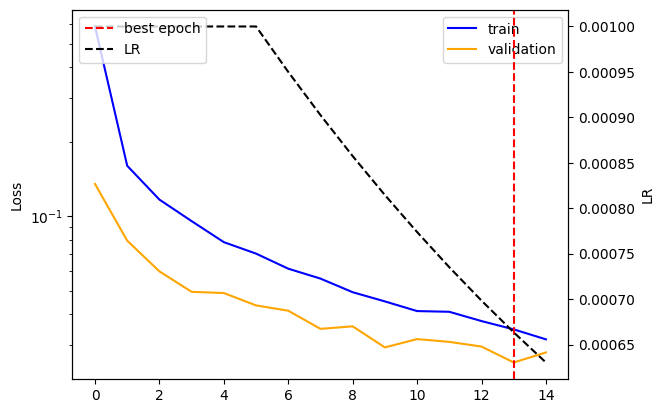

In [ ]:
if TRAIN:
  f,ax = plt.subplots(1,1)
  ax2 = ax.twinx()
  ax.plot(train_curve,label="train",color="blue")
  ax.plot(val_curve,label="validation",color="orange")
  ax2.axvline(best_epoch,color="r",linestyle="--",label="best epoch")
  ax.legend(loc=1)
  ax.set_ylabel("Loss")


  ax2.plot(lr_curve,"k--",label="LR",)
  ax2.legend(loc=2)
  plt.xlabel("Epochs")
  ax2.set_ylabel("LR")
  ax.set_yscale("log")

In [ ]:
model = Net()
model.load_state_dict(torch.load('results/best_weights.pth'))
model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def test_model(model, test_loader):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in test_loader:

            outputs = model(inputs)
            targets = targets.numpy()
            outputs = outputs.numpy()

            predicted = np.argmax(outputs, 1)
            #targets = np.argmax(targets , 1)

            y_true.extend(targets)
            y_pred.extend(predicted)

    cm = confusion_matrix(y_true, y_pred,normalize="true")

    return np.array(y_true), np.array(y_pred), cm

In [ ]:
_,_,cm=test_model(model, testloader)

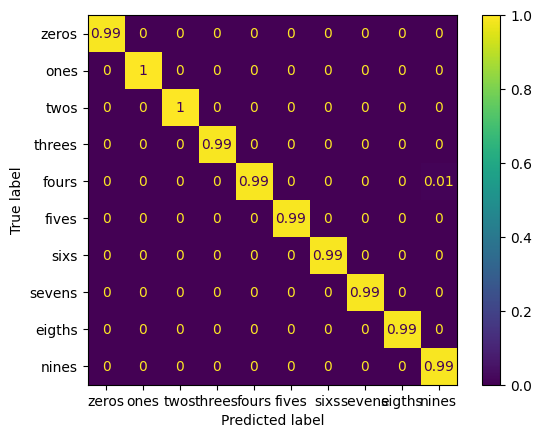

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm,2),
                              display_labels=["zeros","ones", "twos", "threes", "fours","fives","sixs","sevens","eigths","nines"])
disp.plot()

plt.show()

In [ ]:
def compute_integrated_gradient(batch_x, batch_blank, c, model,MODE= "pred",sel=3):
    mean_grad = 0
    n = 32


    for i in range(1, n + 1):
        x = batch_blank + i / n * (batch_x - batch_blank)
        x.requires_grad = True
        y = model(x).squeeze()
        if MODE == "pred":
          c = torch.argmax(y)
          y = y[c]
        if MODE == "sum":
          c = torch.argmax(y)
          y = y.sum()
        if MODE == "sel":
          c = torch.argmax(y)
          y = y[sel]

        #print(y.shape)
        (grad,) = torch.autograd.grad(y, x,is_grads_batched=False)
        mean_grad += grad / n

    integrated_gradients = (batch_x - batch_blank) * mean_grad
    integrated_gradients=integrated_gradients.detach().numpy()
    integrated_gradients = integrated_gradients / np.absolute(integrated_gradients).max()

    return integrated_gradients,c.detach().numpy().squeeze()

In [ ]:
def get_IGs(test_dataset):
  IGs = []
  preds = []

  for i, (r,c) in enumerate(test_dataset):
    batch_x = r.unsqueeze(0)
    batch_blank = torch.zeros_like(batch_x)

    IG,pred = compute_integrated_gradient(batch_x, batch_blank, c, model,MODE="sel")

    IGs.append(IG.squeeze())
    preds.append(pred)

    if i > 127:
      break
  return(IGs,preds)



In [ ]:
def plot_IG(trainset,IGs,preds,to_plot):
  image = trainset[to_plot][0][0].detach().cpu().numpy()
  lab = trainset[to_plot][1]
  IG, pred =  IGs[to_plot],preds[to_plot]
  f,ax = plt.subplots(1,2,figsize=(8,5))
  ax[0].matshow(image,cmap="Greys")
  ax[0].set_title(" class {}".format(lab),fontsize=30)
  ax[1].matshow(IG,cmap="seismic",vmin=-1,vmax=1)
  ax[1].set_title("IG ",fontsize=30)


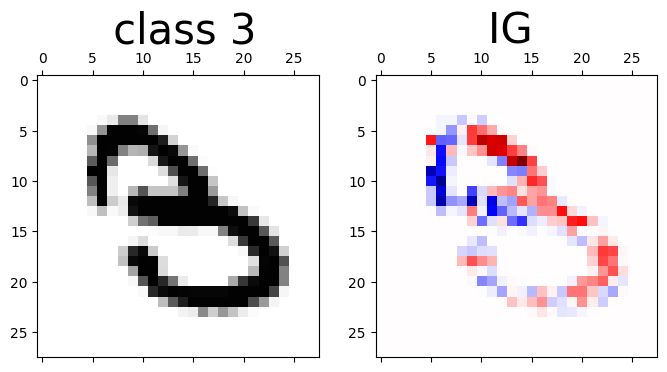

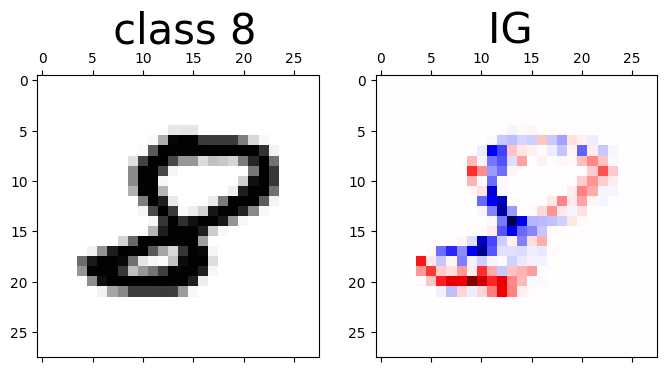

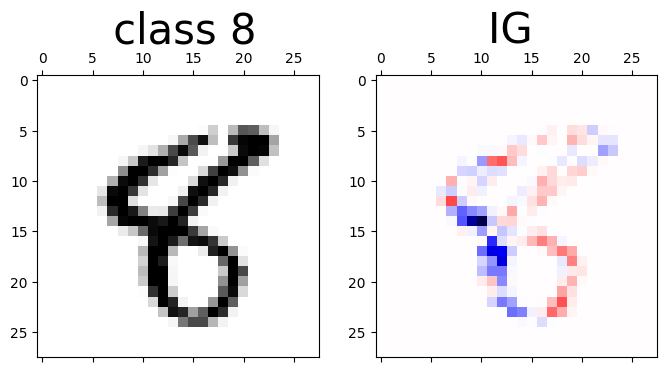

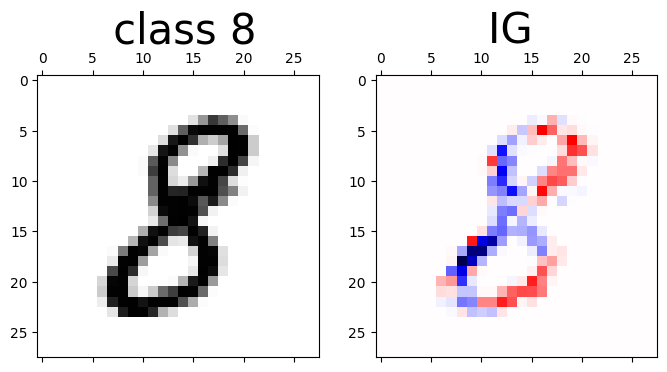

In [ ]:
if 1:
  IGs,preds = get_IGs(testset)
  for to_plot in range(128):
    if preds[to_plot]==8:
      plot_IG(testset,IGs,preds, to_plot)

In [ ]:
im,lab = testset[2]
print(im.shape)
print(lab)

torch.Size([1, 28, 28])
1


In [ ]:
def get_gradients(x,lab, model,device="cpu"):
  #  function that takes a model and a element and returns gradient for that point
  lab=torch.Tensor([lab]).long()
  model.eval()
  loss=0.0
  y = model(x)
  L = criterion(y, lab)
  params = [p for p in model.parameters() if p.requires_grad]
  grads = torch.autograd.grad(L, params )
  return list(grads)

def grad_dot_prod(grad_z0,grad_z1):
  #scalar product for all the gradients (iterated over the list)
    return sum([torch.sum(k*j).data for k,j in zip(grad_z0,grad_z1)]).cpu().numpy()


In [ ]:
grads = get_gradients(im.unsqueeze(0),lab,model)
print(grads[0].shape) # this is the fist conv layer 16 kernels with 3x3 kernel size

torch.Size([16, 1, 3, 3])


In [ ]:
dotp = grad_dot_prod(grads,grads)# test the function
print("this is the gradients module : ", dotp)

this is the gradients module :  1.4386929e-07


In [ ]:
#list of chekpoints that we saved
ckp_list = []
for file in os.listdir("results/"):
    if file.startswith("ckp"):
        print("results/"+file)
        ckp_list.append("results/"+file)
ckp_list.sort()
assert len(lr_ckp  )==len(ckp_list)

results/ckp_10.pth
results/ckp_6.pth
results/ckp_2.pth
results/ckp_8.pth
results/ckp_4.pth
results/ckp_12.pth
results/ckp_14.pth


In [ ]:
def load_model(ckp):
  # a function that load a model given a checkpoint path
  model=Net()
  model.load_state_dict(torch.load(ckp))
  model.eval()
  return model

In [ ]:
def tracIn(dataset,z_test,ckp_list,lr_ckp):
  train_dataset_size = len(dataset)
  ckp_iter=0
  influences = [0.0 for _ in range(train_dataset_size)]

  for c, ckp in enumerate(ckp_list):
    model = load_model(ckp)# carico il checkpoint
    lr=lr_ckp[c]

    im,lab = z_test#test_dataset[2]
    #print(im.shape)
    #print(lab.shape)
    grads_test = get_gradients(im.unsqueeze(0),lab,model)

    for i in range(train_dataset_size):

        im,lab = dataset[i]#test_dataset[2]
        grads_train = get_gradients(im.unsqueeze(0),lab,model)
        dotp = grad_dot_prod(grads_test,grads_train)
        influences[i]+=dotp*lr

  influences = np.array(influences)
  opponents = np.argsort(influences)
  proponents = opponents[::-1]

  return influences, proponents, opponents



In [ ]:
torch.randint(len(trainset), (10,))

tensor([14582,  3450, 45663, 45194, 29990, 40499, 42803, 32203,  7520,   311])

In [ ]:
#cut the dataset so we are faster
import torch.utils.data as data_utils

indices = torch.randint(len(trainset), (512,))
tr_small = data_utils.Subset(trainset, indices)

In [ ]:
influences, proponents, opponents = tracIn(tr_small,testset[2],ckp_list,lr_ckp)

In [ ]:
influences[opponents[-1]]

6.237124208709194e-05

Text(0.5, 0, 'influence score')

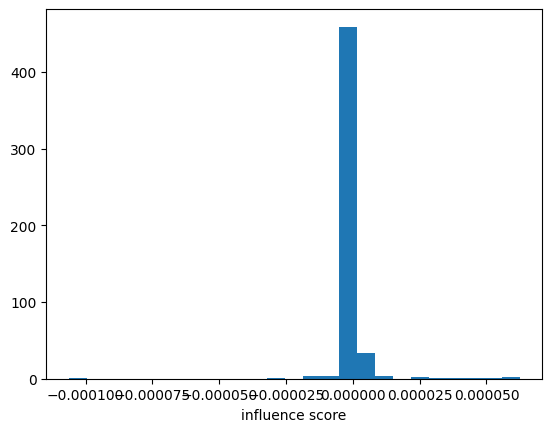

In [ ]:
plt.figure()
_,_,_ = plt.hist(influences,25)
plt.xlabel("influence score")

In [ ]:
proponents

array([363, 385, 245, 180, 227, 251, 375,  12, 162,  75, 395, 215, 253,
       252,  71, 238,  87, 264, 365, 470, 151, 156, 469, 237, 502, 367,
       274, 378, 115, 288, 120, 388, 174, 169, 394,  25, 302, 320, 454,
       290, 419,  35, 305, 103, 125, 466, 381,  68, 325,  99, 361, 220,
        64, 497, 268,  56, 210, 500,  62, 485, 283, 418, 490, 291, 211,
        83, 455, 161, 309, 354, 147, 483, 510, 153, 233, 440, 479, 472,
       123, 380, 178,  60, 249, 105, 442, 352, 273, 359, 321, 293, 333,
       118,  17,  92, 138, 436, 285, 461, 509, 478, 437, 287, 453, 477,
       468, 171,  85, 167,  48,  15,  96, 368, 192,  20, 350, 197,  18,
       430, 141, 465,  55, 323, 498, 266, 295, 247, 357, 473, 480, 236,
       206, 503,  63, 181,   7, 132, 344,  42, 221,  86, 432, 176,  88,
       420, 281, 349, 265, 475, 422, 303, 495, 113, 116,  45, 448, 310,
       360,  40, 275, 346,  93, 159,  31, 150, 341, 342, 351, 491, 235,
       399, 219, 218, 445, 496, 390, 145,  10, 427,   9, 492, 28

In [ ]:
def plot_proponents(dat,train_datatset):
  influences, proponents, opponents = tracIn(train_datatset,dat,ckp_list,lr_ckp)
  image,lab = dat
  image_p, lab_p = train_datatset[proponents[1]]
  image_o, lab_o = train_datatset[opponents[1]]
  image,lab = image.numpy().squeeze(),lab
  image_p,lab_p = image_p.numpy().squeeze(),lab_p
  image_o,lab_o = image_o.numpy().squeeze(),lab_o
  f,ax = plt.subplots(1,3,figsize=(12,5))
  ax[0].matshow(image,cmap="Greys")
  ax[0].set_title(" class {}".format((lab)),fontsize=20)
  ax[1].matshow(image_p,cmap="Greys")
  ax[1].set_title(" Proponent class {}".format((lab_p)),fontsize=20)
  ax[2].matshow(image_o,cmap="Greys")
  ax[2].set_title(" Opponent class {}".format((lab_o)),fontsize=20)


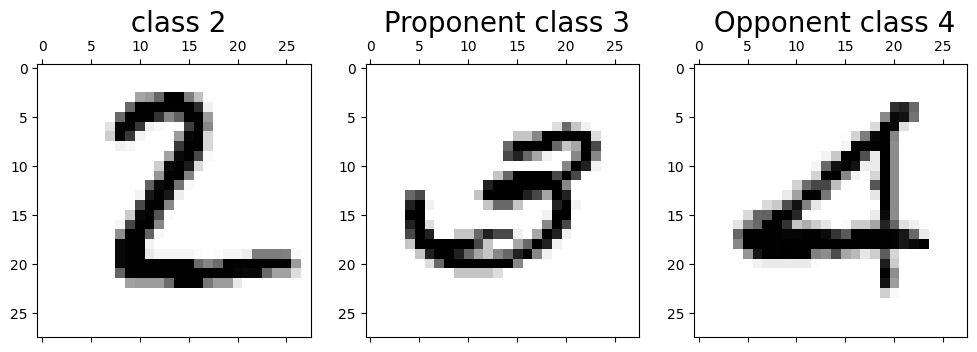

In [ ]:
plot_proponents(testset[1], tr_small)